In [99]:
import tensorflow as tf
from tensorflow.contrib import rnn
import os,re,time
import numpy as np
import pandas as pd
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from keras import backend as K
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split as split

In [4]:
paths = pd.read_csv('11012018.csv',sep='\t',low_memory = False,index_col = False)

In [5]:
paths.head()

,Unnamed: 0,Paths,Fake
0,0,6939 4826 38803 56203,0.0
1,1,6939 4826 38803 56203,0.0
2,2,6939 4826 38803 56203,0.0
3,3,6939 4826 38803 56203,0.0
4,4,6939 4826 38803 56203,0.0


In [6]:
del paths['Unnamed: 0']

In [9]:
train,test = split(paths,test_size = 0.2)

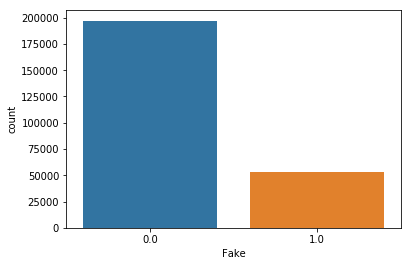

In [85]:
sns.countplot(x = 'Fake',data = train)

In [89]:
train.Fake.value_counts()

0.0    197072
1.0     53164
Name: Fake, dtype: int64

In [90]:
test.Fake.value_counts()

0.0    49258
1.0    13301
Name: Fake, dtype: int64

In [10]:
max_length = 30
vocab_size = 24612 #unique tokens for this file
encoded_train = [one_hot(d,vocab_size) for d in train['Paths']]
encoded_test = [one_hot(d,vocab_size) for d in test['Paths']]
train_lengths = [len(t) for t in encoded_train] #array of lengths so we can pad zeros later
test_lengths= [len(t) for t in encoded_test] #array of lengths for test set to be padded later

In [60]:
class SimpleDataIterator():
    def __init__(self, df):
        self.df = df
        self.size = len(self.df)
        self.epochs = 0
        self.shuffle()

    def shuffle(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        self.cursor = 0

    def next_batch(self, n):
        if self.cursor+n-1 > self.size:
            self.epochs += 1
            self.shuffle()
        res = self.df.ix[self.cursor:self.cursor+n-1]
        self.cursor += n
        return res['data'], res['labels'], res['length']

class PaddedDataIterator(SimpleDataIterator):
    def next_batch(self, n):
        if self.cursor+n > self.size:
            self.epochs += 1
            self.shuffle()
        res = self.df.ix[self.cursor:self.cursor+n-1]
        self.cursor += n

        # Pad sequences with 0s so they are all the same length
        maxlen = max(res['length'])
        x = np.zeros([n, maxlen], dtype=np.int32)
        for i, x_i in enumerate(x):
            x_i[:res['length'].values[i]] = res['data'].values[i]

        return x, res['labels'], res['length']

In [67]:
labels_train = train['Fake']
train_dic={}
train_dic["data"] = encoded_train
train_dic["labels"] = labels_train#labels_train[0].ravel().tolist()
train_dic["length"] = train_lengths
train_len = len(train)
test_len = len(test)

train_ = pd.DataFrame.from_dict(data=train_dic, orient='columns', dtype=None)



test_dic={}
test_dic["data"] = encoded_test
test_dic["length"] = test_lengths
test_dic["labels"] = test['Fake']
test_ = pd.DataFrame.from_dict(data=test_dic, orient='columns', dtype=None)

test_input = test.values

data = SimpleDataIterator(train_)
d = data.next_batch(3)
print('Input sequences\n', d[0], end='\n\n')
print('Target values\n', d[1], end='\n\n')
print('Sequence lengths\n', d[2])

Input sequences
 0                         [7745, 19040]
1    [2722, 18620, 16826, 16826, 16826]
2                      [2169, 91, 7745]
Name: data, dtype: object

Target values
 0    0.0
1    0.0
2    1.0
Name: labels, dtype: float64

Sequence lengths
 0    2
1    5
2    3
Name: length, dtype: int64


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


In [62]:
data = PaddedDataIterator(train_)
train_data = PaddedDataIterator(test_)
d = data.next_batch(3)
print('Input sequences\n', d[0], end='\n\n')

Input sequences
 [[ 7745  7042 20472]
 [21989 24051 19301]
 [12039     0     0]]



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [75]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

In [102]:
def build_graph(
    vocab_size = vocab_size,
    state_size = 24,
    batch_size = 189,
    num_classes = 2):

    reset_graph()

    # Placeholders
    x = tf.placeholder(tf.int32, [batch_size, None]) # [batch_size, num_steps]
    seqlen = tf.placeholder(tf.int32, [batch_size])
    y = tf.placeholder(tf.int32, [batch_size])
    keep_prob = tf.placeholder_with_default(1.0, [])

    # Embedding layer
    embeddings = tf.get_variable('embedding_matrix', [vocab_size, state_size])
    rnn_inputs = tf.nn.embedding_lookup(embeddings, x)

    # RNN
    cell = tf.contrib.rnn.GRUCell(state_size)
    #cell = tf.nn.rnn_cell.BasicLSTMCell(state_size,forget_bias = 1)
    #cell = tf.contrib.rnn.LSTMCell(state_size,forget_bias = 1)
    init_state = tf.get_variable('init_state', [1, state_size],
                                 initializer=tf.constant_initializer(0.0))
    init_state = tf.tile(init_state, [batch_size, 1])
    rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs,dtype=tf.float32)#, sequence_length=seqlen,initial_state=init_state)

    # Add dropout, as the model otherwise quickly overfits
    rnn_outputs = tf.nn.dropout(rnn_outputs, keep_prob)

    """
    Obtain the last relevant output. The best approach in the future will be to use:

        last_rnn_output = tf.gather_nd(rnn_outputs, tf.pack([tf.range(batch_size), seqlen-1], axis=1))

    which is the Tensorflow equivalent of numpy's rnn_outputs[range(30), seqlen-1, :], but the
    gradient for this op has not been implemented as of this writing.

    The below solution works, but throws a UserWarning re: the gradient.
    """
    idx = tf.range(batch_size)*tf.shape(rnn_outputs)[1] + (seqlen - 1)
    last_rnn_output = tf.gather(tf.reshape(rnn_outputs, [-1, state_size]), idx)

    # Softmax layer
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W', [state_size, num_classes])
        b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
    logits = tf.matmul(last_rnn_output, W) + b
    preds = tf.nn.softmax(logits)
    correct = tf.equal(tf.cast(tf.argmax(preds,1),tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    #decayed learning rate
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.1
    learning_rate = tf.train.natural_exp_decay(starter_learning_rate, global_step,20, 0.8, staircase=False)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = y))
    train_step = (tf.train.AdamOptimizer(learning_rate).minimize(loss,global_step = global_step))
    lr_print = tf.Print(learning_rate,[learning_rate])
    return {
        'x': x,
        'seqlen': seqlen,
        'y': y,
        'dropout': keep_prob,
        'loss': loss,
        'ts': train_step,
        'preds': preds,
        'accuracy': accuracy,
        'lr_print': lr_print
    }

In [103]:
def train_graph(graph, sess, batch_size = 1024, num_epochs = 100, iterator = PaddedDataIterator):

    start = time.time()
    sess.run(tf.global_variables_initializer())
    tr = iterator(train_)
    te = iterator(test_)

    step, accuracy = 0, 0
    tr_losses, te_losses = [], []
    current_epoch = 0
    while current_epoch < num_epochs:
        step += 1
        batch = tr.next_batch(batch_size)
        feed = {g['x']: batch[0], g['y']: batch[1], g['seqlen']: batch[2], g['dropout']: 0.8}
        accuracy_, _,l_r = sess.run([g['accuracy'], g['ts'],g['lr_print']], feed_dict=feed)
        accuracy += accuracy_
        #if step >1 and accuracy/step >= 0.97:
        #    print("Accuracy after epoch", current_epoch, " - tr:", accuracy / step)
        #    break;

        if tr.epochs > current_epoch:
            current_epoch += 1
            tr_losses.append(accuracy / step)
            step, accuracy = 0, 0
            #eval test set
            
            te_epoch = te.epochs
            while te.epochs == te_epoch:
                step += 1
                batch = te.next_batch(batch_size)
                feed = {g['x']: batch[0], g['y']: batch[1], g['seqlen']: batch[2]}
                accuracy_ = sess.run([g['accuracy'],g['loss']], feed_dict=feed)[0]
                accuracy += accuracy_
            te_losses.append(accuracy / step)
            step, accuracy = 0,0
            
            if current_epoch%5 == 0:
                print(" - learning rate:", l_r," Accuracy after epoch", current_epoch, " - tr:", tr_losses[-1], "- te:", te_losses[-1])
    end = time.time()
    seconds = end - start
    minutes = seconds//60
    seconds = seconds % 60
    hours = 0
    if minutes > 60:
        hours = minutes//60
        minutes = minutes%60
    print("time taken for training: {0} hours, {1} minutes and {2} seconds".format(hours,minutes,seconds))
    return tr_losses, te_losses

In [104]:
g = build_graph(batch_size = 1024)
#tr_losses, te_losses = train_graph(g)
sess = tf.Session()
tr_losses,te_losses = train_graph(g, sess)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


 - learning rate: 6.40368e-23  Accuracy after epoch 5  - tr: 0.9596687692110656 - te: 0.9600569928278688
 - learning rate: 0.0  Accuracy after epoch 10  - tr: 0.959564709272541 - te: 0.9599769467213115
 - learning rate: 0.0  Accuracy after epoch 15  - tr: 0.9596687692110656 - te: 0.9601210297131147
 - learning rate: 0.0  Accuracy after epoch 20  - tr: 0.9598208568135246 - te: 0.9602491034836066
 - learning rate: 0.0  Accuracy after epoch 25  - tr: 0.9595967277151639 - te: 0.9602010758196722
 - learning rate: 0.0  Accuracy after epoch 30  - tr: 0.9597528176229508 - te: 0.9600730020491803
 - learning rate: 0.0  Accuracy after epoch 35  - tr: 0.9596047323258197 - te: 0.9603291495901639
 - learning rate: 0.0  Accuracy after epoch 40  - tr: 0.9597328060963115 - te: 0.9604892418032787
 - learning rate: 0.0  Accuracy after epoch 45  - tr: 0.9596927830430327 - te: 0.9603131403688525
 - learning rate: 0.0  Accuracy after epoch 50  - tr: 0.9597047899590164 - te: 0.9601850665983607
 - learning ra

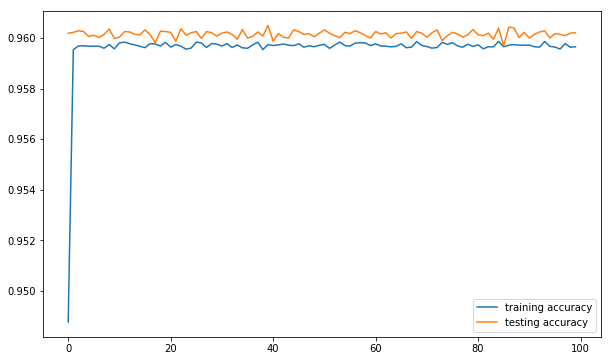

In [108]:
plt.figure(figsize = (10,6))
plt.plot(tr_losses,label = 'training accuracy')
plt.plot(te_losses,label = 'testing accuracy')
plt.legend()